# Chicago data by block

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
import os, lzma, csv, bz2, io, collections, pickle
import pyproj
import tilemapbase
import shapely.geometry

import open_cp.sources.chicago

In [2]:
data_dir = os.path.join("/media", "disk", "Data")
data_dir = os.path.join("..", "..", "..", "..", "Data")
#os.listdir(data_dir)
filename = os.path.join(data_dir, "chicago_all.csv.xz")

Ignore data from 2001 which is geo-coded in a different way.

In [3]:
with lzma.open(filename, "rt", encoding="utf8") as f:
    reader = csv.reader(f)
    header = next(reader)
    out = collections.defaultdict(list)
    data = []
    for row in reader:
        if row[15] == "":
            continue
        year = int(row[17])
        if year <= 2001:
            continue
        block, x, y = row[3], float(row[15]), float(row[16])
        x /= open_cp.sources.chicago._FEET_IN_METERS
        y /= open_cp.sources.chicago._FEET_IN_METERS
        out[block].append((x,y))
        data.append((block, x, y, row[5], row[6], row[7]))
out = {k : np.asarray(out[k]) for k in out}
len(out)

51663

### Compute distances

In [4]:
dists = dict()
for k in out:
    x, y = out[k][:,0], out[k][:,1]
    d = (x - np.mean(x))**2 + (y - np.mean(y))**2
    dists[k] = np.sqrt(np.max(d))

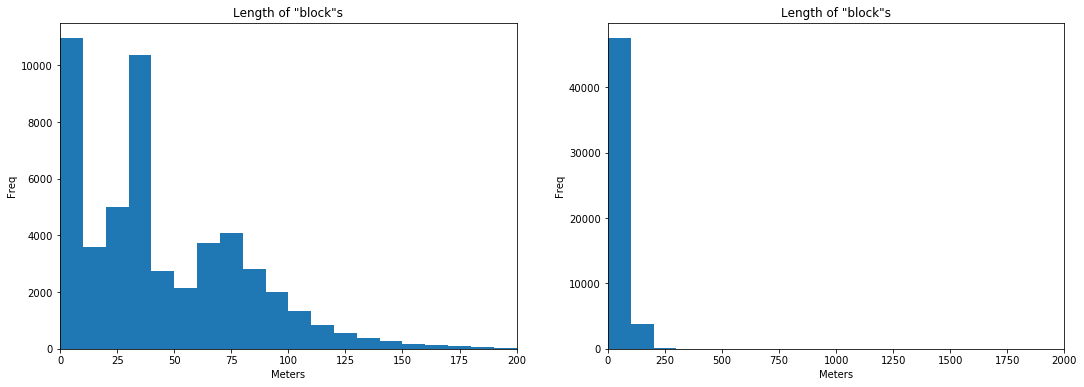

In [5]:
fig, axes  = plt.subplots(ncols=2, figsize=(18,6))

ax = axes[0]
ax.hist( list(dists.values()), bins=np.linspace(0,200,21) )
ax.set(xlim=[0,200], xlabel="Meters", ylabel="Freq", title="""Length of "block"s""")

ax = axes[1]
ax.hist( list(dists.values()), bins=np.linspace(0,2000,21) )
ax.set(xlim=[0,2000], xlabel="Meters", ylabel="Freq", title="""Length of "block"s""")
None

But there is a long tail, which needs looking at (is it errors?)

In [26]:
proj = pyproj.Proj({"init":"epsg:3528"})

allx, ally = [], []
for k in out:
    x, y = out[k].T
    allx.extend(x)
    ally.extend(y)
allx, ally = proj(allx, ally, inverse=True)
allxt, allyt = [], []
for x, y in zip(allx, ally):
    x, y = tilemapbase.project(x, y)
    allxt.append(x)
    allyt.append(y)
allxt, allyt = np.asarray(allxt), np.asarray(allyt)

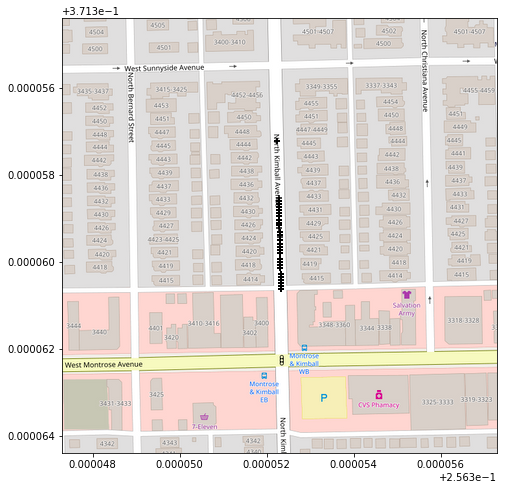

In [7]:
k = list(out)[6]
x, y = proj(*out[k].T, inverse=True)

ex = tilemapbase.Extent.from_centre_lonlat(np.mean(x), np.mean(y), xsize=0.00001)
plotter = tilemapbase.Plotter(ex, tilemapbase.tiles.OSM, width=400)

fig, ax = plt.subplots(figsize=(8,8))
plotter.plot(ax)

xcs, ycs = [], []
for xx, yy in zip(x, y):
    xx, yy = tilemapbase.project(xx, yy)
    xcs.append(xx)
    ycs.append(yy)
ax.scatter(xcs, ycs, marker="+", color="black")

5.5554405208025699

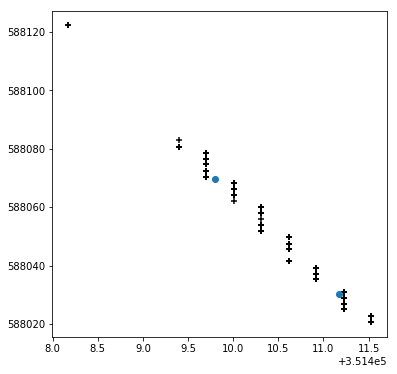

In [8]:
import scipy.cluster

centroids, d = scipy.cluster.vq.kmeans(out[k], 2)

fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(*out[k].T, marker="+", color="black")
ax.scatter(*centroids.T)
d

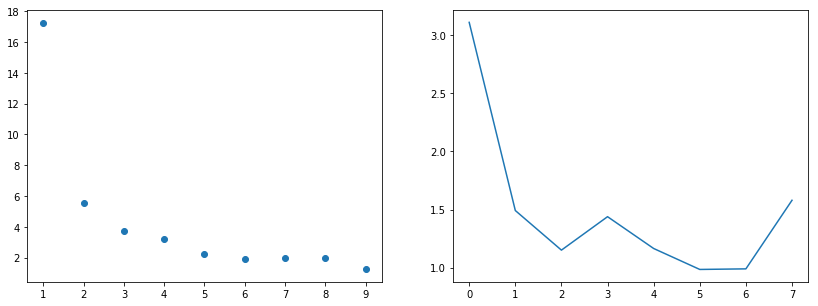

In [9]:
distortion = []
for kk in range(1,10):
    _, d = scipy.cluster.vq.kmeans(out[k], kk)
    distortion.append(d)
    
fig, axes = plt.subplots(ncols=2, figsize=(14,5))
axes[0].scatter(range(1,10), distortion)
distortion = np.asarray(distortion)
axes[1].plot(distortion[:-1] / distortion[1:])

### What do we expect for a straight line??

0.12589616892238531

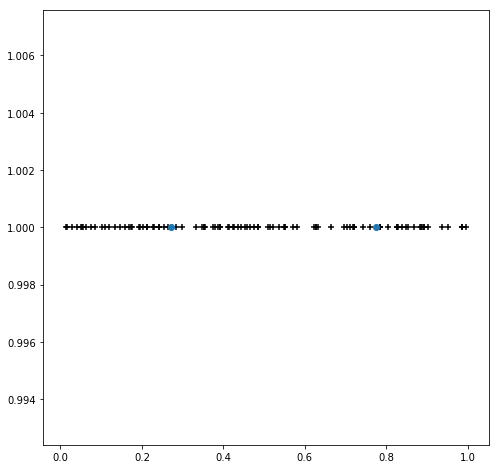

In [10]:
data = np.asarray([[x,1] for x in np.random.random(100)])
centroids, d = scipy.cluster.vq.kmeans(data, 2)
fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(*data.T, marker="+", color="black")
ax.scatter(*centroids.T)
d

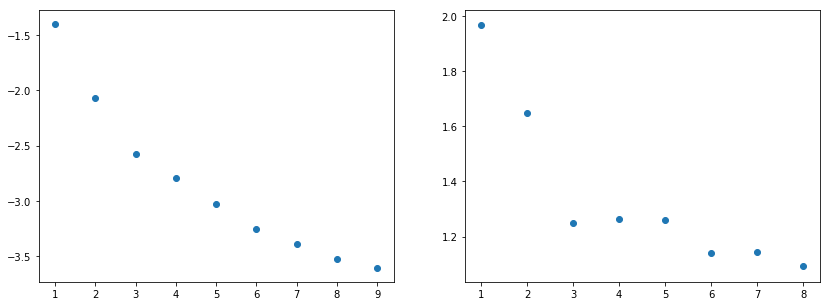

In [11]:
distortion = []
for kk in range(1,10):
    _, d = scipy.cluster.vq.kmeans(data, kk)
    distortion.append(d)
fig, axes = plt.subplots(ncols=2, figsize=(14,5))
axes[0].scatter(range(1,10), np.log(distortion))
distortion = np.asarray(distortion)
axes[1].scatter(range(1,9), distortion[:-1] / distortion[1:])

# Try drawing circles...

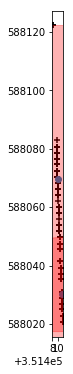

In [12]:
import matplotlib.patches

#k = list(out)[4]
kk = 2
#centroids, labels = scipy.cluster.vq.kmeans2(out[k], kk)
centroids, _ = scipy.cluster.vq.kmeans(out[k], kk)

labels = []
for x,y in out[k]:
    d = (centroids - np.asarray([x,y]))**2
    d = np.sqrt(np.sum(d, axis=1))
    labels.append(np.argmin(d))
labels = np.asarray(labels)

fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(*out[k].T, marker="+", color="black")
ax.scatter(*centroids.T)

radii = []
for la in range(kk):
    d = (out[k][labels == la, :] - centroids[la])**2
    d = np.sqrt(np.sum(d, axis=1))
    radii.append(np.max(d))
    c = matplotlib.patches.Circle(centroids[la], radii[-1], alpha=0.3, color="red")
    ax.add_patch(c)

ax.set_aspect(1)

In [13]:
centroids.shape

(2, 2)

## Another thought- lines

Let's try to enclose each "block" in a rectangle...

0.38391574006527662

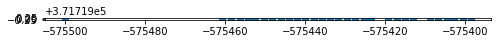

In [14]:
angle = 88 / 180 * np.pi
data = out[k]

xcs = np.cos(angle) * data[:,0] - np.sin(angle) * data[:,1]
ycs = np.sin(angle) * data[:,0] + np.cos(angle) * data[:,1]

xmin, xmax = np.min(xcs), np.max(xcs)
ymin, ymax = np.min(ycs), np.max(ycs)

fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(xcs, ycs)
ax.set_aspect(1)

ymax - ymin

In [15]:
import scipy.optimize

def to_coords(angle, data):
    xcs = np.cos(angle) * data[:,0] - np.sin(angle) * data[:,1]
    ycs = np.sin(angle) * data[:,0] + np.cos(angle) * data[:,1]
    return xcs, ycs

def score(angle, data):
    xcs, ycs = to_coords(angle, data)
    ymin, ymax = np.min(ycs), np.max(ycs)
    return ymax - ymin

def bias(data):
    def f(a):
        return score(a, data)
    angle = scipy.optimize.brute(f, [[0, 2*np.pi]])[0]
    
    xcs, ycs = to_coords(angle, data)
    xmin, xmax = np.min(xcs), np.max(xcs)
    ymin, ymax = np.min(ycs), np.max(ycs)
    xd, yd = xmax - xmin, ymax - ymin
    return yd / xd

bias(data)

0.0029999261153408493

In [28]:
for k in out:
    b = bias( out[k] )
    if b > 0.02:
        print(k, b)
        break

062XX S DORCHESTER AVE 0.0335837238302


(-87.591394086099925, 41.781677266427891)

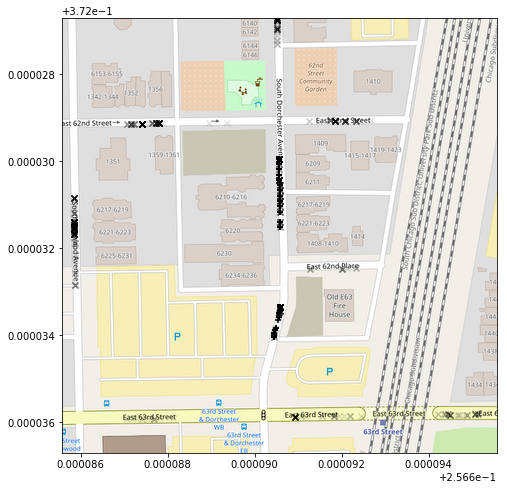

In [31]:
x, y = proj(*out[k].T, inverse=True)

ex = tilemapbase.Extent.from_centre_lonlat(np.mean(x), np.mean(y), xsize=0.00001)
plotter = tilemapbase.Plotter(ex, tilemapbase.tiles.OSM, width=400)

fig, ax = plt.subplots(figsize=(8,8))
plotter.plot(ax)

xcs, ycs = [], []
for xx, yy in zip(x, y):
    xx, yy = tilemapbase.project(xx, yy)
    xcs.append(xx)
    ycs.append(yy)
ax.scatter(xcs, ycs, marker="+", color="black")
ax.scatter(allxt, allyt, marker="x", color="black", alpha=0.1)
np.mean(x), np.mean(y)

0.033583723830175993

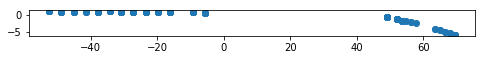

In [30]:
angle = 88 / 180 * np.pi
data = out[k]

xcs = np.cos(angle) * data[:,0] - np.sin(angle) * data[:,1]
ycs = np.sin(angle) * data[:,0] + np.cos(angle) * data[:,1]
xcs -= np.mean(xcs)
ycs -= np.mean(ycs)

fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(xcs, ycs)
ax.set_aspect(1)

bias(data)